In [1]:
# Process for Training:
# 1. L̶o̶a̶d̶ ̶i̶n̶ ̶i̶m̶a̶g̶e̶ ̶a̶n̶d̶ ̶m̶a̶k̶e̶ ̶i̶t̶ ̶5̶1̶2̶x̶5̶1̶2̶  I will do preprocessing before to make file sizes smaller for training.
# 2. Apply various pertubations/distortions on image
# 3. Clone image, and create the generator copy (this is what is fed to generator)


# The functions defined below are configured such that you input a single tfrecord and it will return
# what you need to feed to the generator and what you need to feed to the discriminator

# The generator image will be cut such that it hides 56 pixels from each side

# In this script, we require a TFrecord on pre-processed data to be exactly 512x512x3.
# This results in smaller file sizes so it is easier to train on and can be cached / stored on memory.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

def parse_tfrecord_fn(example_proto):
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(example['image_raw'], channels=3)
    return image
############################
# Vectorized 

def resize(input_image, height, width):
    return tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def _random_crop(input_image, height, width, batch_size):
    return tf.image.random_crop(input_image, size=[batch_size, height, width, 3])

# Normalizing the images to [-1, 1]
def normalize(input_image):
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_image = (input_image / 127.5) - 1 # want a mean near 0
    return input_image

def denormalize(input_image):
    input_image = (input_image + 1) * 127.5
    input_image = tf.cast(input_image, dtype=tf.int64)
    return input_image

@tf.function()
def _random_jitter(input_image, batch_size):
    # Resizing to 542x542
    input_image = resize(input_image, 542, 542)
    # Random cropping back to 512x512
    input_image= _random_crop(input_image, 512, 512, batch_size)
    # Random mirroring
    input_image = tf.image.random_flip_left_right(input_image)
    # Normalizing image
    input_image = normalize(input_image)
    return input_image

def _generator_image(input_image, buffer=56):
    height = 512 #len(input_image[0][0])
    width = 512 #len(input_image[0][1])
    paddings = tf.constant([[0,0],[buffer, buffer], [buffer, buffer], [0, 0]])
    generator_image = tf.pad(input_image[:, buffer:(height-buffer), buffer:(width-buffer), :], 
                             paddings, constant_values=0) # constant values should probably cycle between -1 and 1
    return generator_image

# For loading the TfRecord
def load_tfrecord(tfrecord_file, batch_size, buffer=56):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache() # Store the loaded data into memory
    dataset = dataset.batch(batch_size) # Batch every epoch, dont store batches in memory
    dataset = dataset.map(lambda x: _random_jitter(x, batch_size), num_parallel_calls=tf.data.AUTOTUNE) 
    dataset = dataset.map(lambda x: (_generator_image(x, buffer), x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE) # prefetch to speed up subsequent computations
    return dataset

In [3]:
tfrecord_path = "C:\\Users\\Ilyas\\Desktop\\images.tfrecord"
BUFFER_SIZE = 400
BATCH_SIZE = 1

dataset1 = load_tfrecord(tfrecord_path, BATCH_SIZE)


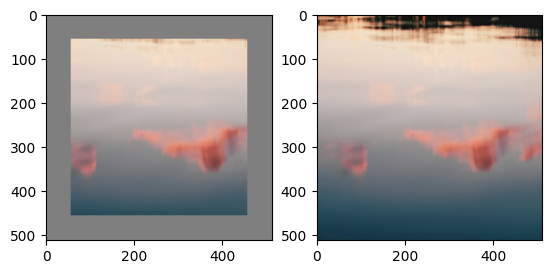

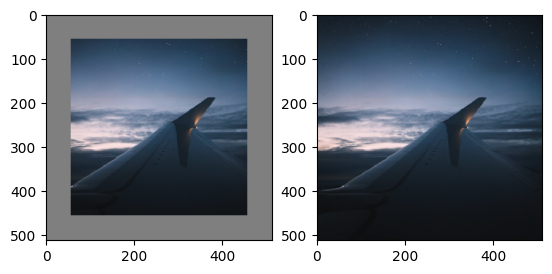

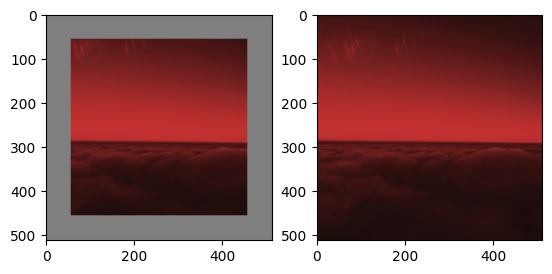

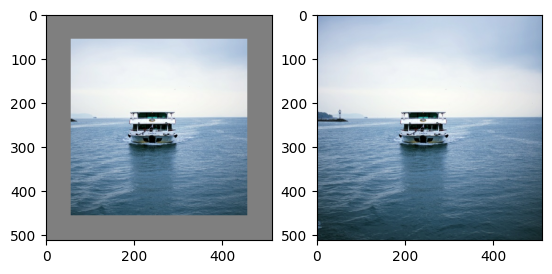

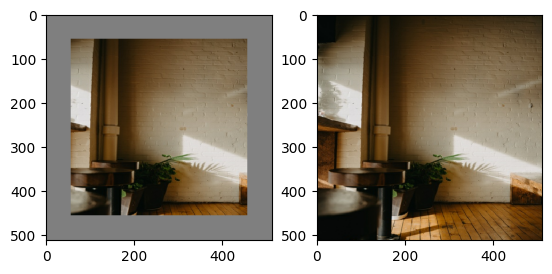

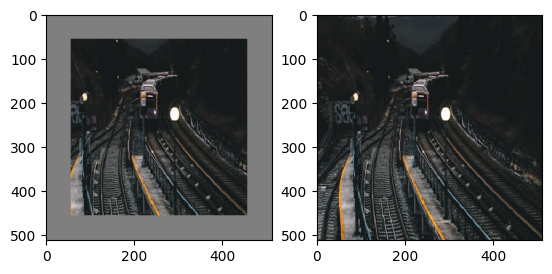

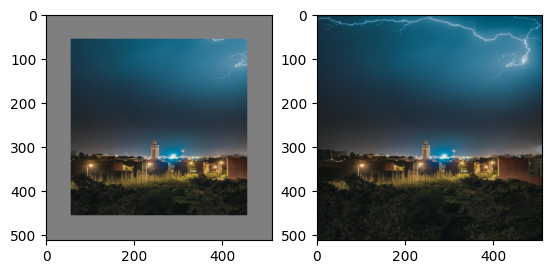

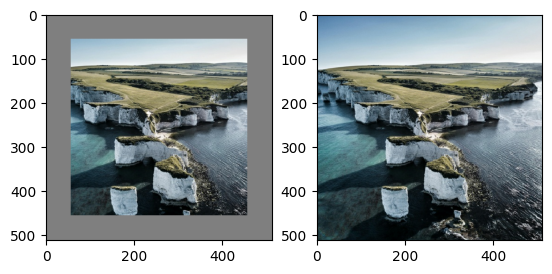

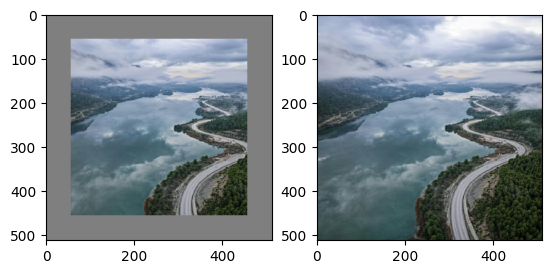

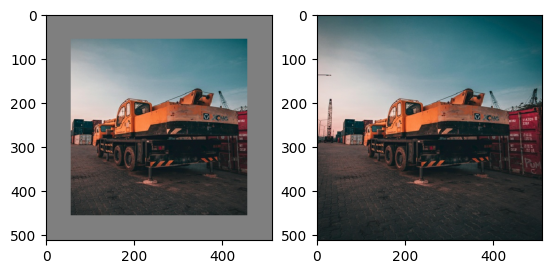

3.980250120162964


In [6]:
import time
start =time.time()

for gen_image, real_image in dataset1.take(10):
    for i in range(BATCH_SIZE):
        plt.subplot(1,2,1)
        plt.imshow(denormalize(gen_image[i]))
        plt.subplot(1,2,2)
        plt.imshow(denormalize(real_image[i]))
        plt.show()

print(time.time()-start)
# image = train_image_load('2.jpg')
# plt.imshow(image[0])
# plt.show()
# plt.imshow(image[1])